### Importing all the necessary libraries

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import  Flatten, Dense
from sklearn.metrics import label_ranking_average_precision_score
from tensorflow.keras.metrics import Metric
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B2

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import librosa
import os
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import IPython

tf.random.set_seed(21)
np.random.seed(21)
from google.colab import drive
drive.mount('/content/gdrive')
%matplotlib inline
params = {'figure.figsize' : (12,8),'legend.fontsize': 12,'legend.handlelength': 3,'axes.titlesize' : 'large'}
plt.rcParams.update(params)

Mounted at /content/gdrive


In [4]:
#Configuration Class
class Config():
    def __init__(self, sampling_rate, n_classes=80):
        self.sampling_rate=sampling_rate
        self.n_classes=n_classes
        self.stft_window_seconds=0.025
        self.stft_hop_seconds=0.010
        self.mel_bands=96
        self.mel_min_hz=20
        self.mel_max_hz=20000
        self.mel_log_offset=0.001
        self.example_window_seconds=1.0
        self.example_hop_seconds=0.5

In [5]:
# 44100Hz is the sampling rate
config = Config(44100)

In [6]:
TRAIN_FILES_DIRECTORY = r'/content/gdrive/MyDrive/Freesound_new/train_combined/'

### Creating the Duration column

In [7]:
df_train = pd.read_csv('/content/gdrive/MyDrive/Freesound_new/df_combined.csv')
df_train=df_train[df_train.label_count<6]
df_train.drop(['label_count'],axis=1,inplace=True)
df_train.reset_index(drop=True,inplace=True)
df_train.head()

fname           labels
0  0006ae4e.wav             Bark
1  0019ef41.wav         Raindrop
2  001ec0ad.wav  Finger_snapping
3  0026c7cb.wav              Run
4  0026f116.wav  Finger_snapping

In [8]:
dir_train = r'/content/gdrive/MyDrive/Freesound_new/'

In [ ]:
count1 = 0 
count2 = 0
missing_count = 0
duration ={}
for idx,item in enumerate(df_train['fname']):

  # Load an audio file
  audio_file = os.path.join(dir_train,'train_curated',item)
  if(os.path.exists(audio_file)):
    y, sr = librosa.load(audio_file)

    # Get the duration of the audio file
    duration_t = librosa.get_duration(y=y, sr=sr)

    print(f'The duration of the audio file {audio_file} is {duration_t:.2f} seconds')
    count1=count1+1
  else:
    audio_file = os.path.join(dir_train,'Val',item)
    if(os.path.exists(audio_file)):
      y, sr = librosa.load(audio_file)

      # Get the duration of the audio file
      duration_t = librosa.get_duration(y=y, sr=sr)

      print(f'The duration of the audio file {audio_file} is {duration_t:.2f} seconds')
      count2=count2+1
    else:
      print(f'Missed audio file {audio_file}')
      missing_count=missing_count+1
      duration_t = 0
  duration[idx] = duration_t

print(count1)
print(count2)
print(missing_count)

The duration of the audio file /content/gdrive/MyDrive/Freesound_new/train_curated/0006ae4e.wav is 7.04 seconds
The duration of the audio file /content/gdrive/MyDrive/Freesound_new/train_curated/0019ef41.wav is 2.05 seconds
The duration of the audio file /content/gdrive/MyDrive/Freesound_new/train_curated/001ec0ad.wav is 1.52 seconds
The duration of the audio file /content/gdrive/MyDrive/Freesound_new/train_curated/0026c7cb.wav is 25.53 seconds
The duration of the audio file /content/gdrive/MyDrive/Freesound_new/train_curated/0026f116.wav is 1.38 seconds
The duration of the audio file /content/gdrive/MyDrive/Freesound_new/train_curated/003be5db.wav is 14.14 seconds
The duration of the audio file /content/gdrive/MyDrive/Freesound_new/train_curated/0041de6b.wav is 8.04 seconds
The duration of the audio file /content/gdrive/MyDrive/Freesound_new/Val/004ca909.wav is 0.83 seconds
The duration of the audio file /content/gdrive/MyDrive/Freesound_new/Val/00713ec2.wav is 0.42 seconds
The durati

In [ ]:
duration

In [ ]:
df_duration = df_train.from_dict(duration,orient='index',columns=['duration'])
df_duration

In [ ]:
df_train=df_train.join(df_duration)
df_train.to_csv('/content/gdrive/MyDrive/Freesound_new/df_train_withduration.csv')

In [9]:
df_train = pd.read_csv('/content/gdrive/MyDrive/Freesound_new/df_train_withduration.csv')
df_train=df_train.drop("Unnamed: 0",axis=1)

In [10]:
df_train

fname           labels   duration
0     0006ae4e.wav             Bark   7.039819
1     0019ef41.wav         Raindrop   2.054785
2     001ec0ad.wav  Finger_snapping   1.518730
3     0026c7cb.wav              Run  25.530295
4     0026f116.wav  Finger_snapping   1.375011
...            ...              ...        ...
4964  ffd4ed26.wav        Tick-tock  26.749161
4965  ffdc411e.wav             Slam  17.682041
4966  ffe2178b.wav              Bus   6.069569
4967  fffa69b7.wav  Electric_guitar   0.945306
4968  ffff4631.wav             Meow  27.826757

[4969 rows x 3 columns]

###Functions

In [11]:
## inspired from this paper and the winners of kaggle competition https://arxiv.org/pdf/1906.02975v4.pdf
def clipwave(clip, clip_dir=None):
    """Decodes a WAV clip into a waveform tensor where the values lie in [-1, +1].

    Args:
        clip (str): Path to .wav file, e.g., 'file1.wav'.
        clip_dir (str, optional): Parent folder in which the above clips is stored, e.g., 'preprocessed_dir'.

    Returns:
        tf.Tensor: Tensor corresponding to the clip with all values between -1 to 1.
    """
    path = tf.strings.join([clip_dir, clip])
    data = tf.io.read_file(path)
    wave, sr = tf.audio.decode_wav(data)
    return tf.squeeze(wave)


def clip_log_mel(clip, clip_dir=None):
    """Decodes a WAV clip into a batch of log mel spectrum examples.

    This function takes the given .wav file, gets its tensor representation, converts it into spectrogram using short-time
    Fourier transform, then converts the spectrogram into log mel spectrogram, finally, it divides it into various windows
    and returns all the windows in a 3-channel format.

    Args:
        clip (str): Path to .wav file, e.g., 'file1.wav'.
        clip_dir (str, optional): Parent folder in which the above clips is stored, e.g., 'preprocessed_dir'.

    Returns:
        tf.Tensor: Log mel spectrogram windowed features.
    """
    # Decode WAV clip into waveform tensor.
    form_wave = clipwave(clip, clip_dir=clip_dir)

    # Convert waveform into spectrogram using a Short-Time Fourier Transform.
    # Note that tf.signal.stft() uses a periodic Hann window by default.
    window_length_samples = int(round(config.sampling_rate * config.stft_window_seconds))
    hop_length_samples = int(round(config.sampling_rate * config.stft_hop_seconds))
    fft_length = 2 ** int(np.ceil(np.log2(window_length_samples)))
    
    magnitude_spectrogram = tf.math.abs(tf.signal.stft(signals=form_wave,
                                                       frame_length=window_length_samples,
                                                       frame_step=hop_length_samples,
                                                       fft_length=fft_length))

    # Convert spectrogram into log mel spectrogram.
    num_spectrogram_bins = fft_length // 2 + 1
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(num_mel_bins=config.mel_bands,
                                                                        num_spectrogram_bins=num_spectrogram_bins,
                                                                        sample_rate=config.sampling_rate,
                                                                        lower_edge_hertz=config.mel_min_hz,
                                                                        upper_edge_hertz=config.mel_max_hz)
    mel_spectrogram = tf.matmul(magnitude_spectrogram, linear_to_mel_weight_matrix)
    log_mel_spectrogram = tf.math.log(mel_spectrogram + config.mel_log_offset)

    # Frame log mel spectrogram into examples.
    spectrogram_sr = 1 / config.stft_hop_seconds
    example_window_length_samples = int(round(spectrogram_sr * config.example_window_seconds))
    example_hop_length_samples = int(round(spectrogram_sr * config.example_hop_seconds))
    features = tf.signal.frame(signal=log_mel_spectrogram,
                               frame_length=example_window_length_samples,
                               frame_step=example_hop_length_samples,
                               pad_end=True,
                               pad_value=0.0,
                               axis=0)
    
    # Converting mono channel to 3 channels    
    features = mono_to_color(features)
    features=tf.stack([features,features,features], axis=-1)  
    print(features,type(features))
    return features

def mono_to_color(X, mean=None, std=None, norm_max=None, norm_min=None, eps=1e-6):
    """
    Description - The mono_to_color function converts a grayscale image to a colored image. It applies standardization to the input 
                  data and then normalizes it between the values of norm_min and norm_max. If the difference between the minimum and
                  maximum values is greater than eps, it then maps the normalized values to the range [0, 255] to obtain a colored 
                  image. If the difference is smaller than eps, the function returns a tensor of zeros with the same shape as the 
                  input tensor. If the mean and std parameters are not provided, the function calculates them from the input tensor.
                  If norm_min and norm_max are not provided, the function calculates them from the normalized input tensor. 
                  The eps parameter is used to avoid division by zero.
    """    
    # Standardize
    mean = mean or tf.math.reduce_mean(X)
    std = std or tf.math.reduce_std(X)
    Xstd = (X - mean) / (std + eps)
    _min, _max = tf.math.reduce_min(Xstd), tf.math.reduce_max(Xstd)
    norm_max = norm_max or _max
    norm_min = norm_min or _min
    if (_max - _min) > eps:
        # Normalize to [0, 255]
        V = Xstd
        V = tf.where(V < norm_min, norm_min, V)
        V = tf.where(V > norm_max, norm_max, V)
        V = 255 * (V - norm_min) / (norm_max - norm_min)
        V = tf.cast(V, tf.float32)
    else:
        # Just zero
        V = tf.zeros_like(Xstd, dtype=tf.float32)
    return V

def record_to_labeled_log_mel_examples(csv_record, clip_dir=None, label_class_index_table=None, num_classes=None):
    """
    Creates a batch of log mel spectrum examples from a training record.

    Args:
        csv_record: str, a line from a training CSV file downloaded from Kaggle
        clip_dir: str, optional, path to a directory containing clips referenced by csv_record
        label_class_index_table: tf.lookup.StaticHashTable, optional, a lookup table that represents the class map
        num_classes: int, optional, number of classes in the class map

    Returns:
        features: tf.Tensor, a batch of log mel spectrum examples
        labels: tf.Tensor, corresponding labels in 1-hot format
    """
    # Decode the CSV record
    clip, labels_str = tf.io.decode_csv(csv_record, record_defaults=[[''], ['']])
    
    # Extract log mel spectrum features
    features = clip_log_mel(clip, clip_dir=clip_dir)
    
    # Split label string and get corresponding class indices
    clip_labels = tf.strings.split([labels_str], sep=',').values
    class_indices = label_class_index_table.lookup(clip_labels)
    
    # One-hot encode class indices and reduce to a multi-hot encoding
    label_onehots = tf.one_hot(indices=class_indices, depth=num_classes)
    label_multihot = tf.math.reduce_max(label_onehots, axis=[0], keepdims=False)
    
    # Tile multi-hot encoding to match the number of log mel spectrum examples
    num_examples = tf.shape(features)[0]
    labels = tf.tile([label_multihot], [num_examples, 1])
    
    return features, labels


def fetch_map(class_map_path):
    """
    Constructs a class label lookup table from a class map.

    Args:
        class_map_path: str, path to the class_map.csv file which contains the mapping of each unique class label to an integer from 0-79

    Returns:
        label_class_index_table: tf.lookup.StaticHashTable, lookup table mapping each class label to a unique integer
        num_classes: int, total number of unique classes
    """
    # Construct a lookup table from the class map file
    label_class_index_table = tf.lookup.StaticHashTable(
        tf.lookup.TextFileInitializer(filename=class_map_path,
                                       key_dtype=tf.string,
                                       key_index=1,
                                       value_dtype=tf.int32,
                                       value_index=0,
                                       delimiter=','),
        default_value=-1)
    
    # Count the number of classes in the class map file
    with open(class_map_path) as f:
        num_classes = sum(1 for _ in f)
    
    return label_class_index_table, num_classes

In [12]:
df_combined=pd.read_csv('/content/gdrive/MyDrive/Freesound_new/df_combined.csv')
df_combined.drop(['label_count'],axis=1).to_csv('/content/gdrive/MyDrive/Freesound_new/df_combined1.csv',index=False)

In [13]:
df_combined=pd.read_csv('/content/gdrive/MyDrive/Freesound_new/df_combined1.csv')
df_combined

fname           labels
0     0006ae4e.wav             Bark
1     0019ef41.wav         Raindrop
2     001ec0ad.wav  Finger_snapping
3     0026c7cb.wav              Run
4     0026f116.wav  Finger_snapping
...            ...              ...
4964  ffd4ed26.wav        Tick-tock
4965  ffdc411e.wav             Slam
4966  ffe2178b.wav              Bus
4967  fffa69b7.wav  Electric_guitar
4968  ffff4631.wav             Meow

[4969 rows x 2 columns]

### Models & Mapping

In [14]:
AUTOTUNE = tf.data.AUTOTUNE
train_csv_path = '/content/gdrive/MyDrive/Freesound_new/df_combined1.csv'
class_map_path = '/content/gdrive/MyDrive/Freesound_new/class_map.csv'
label_class_index_table, num_classes = fetch_map(class_map_path)
train_dataset = tf.data.TextLineDataset(train_csv_path)
train_dataset = train_dataset.skip(1)
train_dataset = train_dataset.map(lambda x: record_to_labeled_log_mel_examples(x,
                                                                               clip_dir=TRAIN_FILES_DIRECTORY,
                                                                               label_class_index_table=label_class_index_table,
                                                                               num_classes=num_classes),
                                  num_parallel_calls=AUTOTUNE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Tensor("stack:0", dtype=float32) <class 'tensorflow.python.framework.ops.Tensor'>


In [15]:
train_dataset

<ParallelMapDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(None, 80), dtype=tf.float32, name=None))>

### Defining the scoring metric: LWLRAP

In [16]:
# Reference implementation from: https://colab.research.google.com/drive/1AgPdhSp7ttY18O3fEoHOQKlt_3HJDLi8
def _lwlrap_sklearn(truth, scores):
    '''
    Description -> Return the Label Weighted Label Ranking Average Precision (LWLRAP) of the given true and predicted
    class labels
    
    Inputs ->
    truth: OHE Vector of truth class label
    scores: NumPy array of predictions
    
    Output -> LWLRAP score
    '''
    sample_weight = np.sum(truth > 0, axis=1)
    nonzero_weight_sample_indices = np.flatnonzero(sample_weight > 0)
    overall_lwlrap = label_ranking_average_precision_score(
        truth[nonzero_weight_sample_indices, :] > 0, 
        scores[nonzero_weight_sample_indices, :], 
        sample_weight=sample_weight[nonzero_weight_sample_indices])
    return overall_lwlrap


def _one_sample_positive_class_precisions(example):
    y_true, y_pred = example
    retrieved_classes = tf.argsort(y_pred, direction='DESCENDING')
    class_rankings = tf.argsort(retrieved_classes)
    retrieved_class_true = tf.gather(y_true, retrieved_classes)
    retrieved_cumulative_hits = tf.math.cumsum(tf.cast(retrieved_class_true, tf.float32))

    idx = tf.where(y_true)[:, 0]
    i = tf.boolean_mask(class_rankings, y_true)
    r = tf.gather(retrieved_cumulative_hits, i)
    c = 1 + tf.cast(i, tf.float32)
    precisions = r / c
    dense = tf.scatter_nd(idx[:, None], precisions, [y_pred.shape[0]])
    return dense

class LWLRAP(Metric):
    def __init__(self, num_classes, name='lwlrap'):
        super().__init__(name=name)

        self._precisions = self.add_weight(
            name='per_class_cumulative_precision',
            shape=[num_classes],
            initializer='zeros')

        self._counts = self.add_weight(
            name='per_class_cumulative_count',
            shape=[num_classes],
            initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        precisions = tf.map_fn(
            fn=_one_sample_positive_class_precisions,
            elems=(y_true, y_pred),
            dtype=(tf.float32))

        increments = tf.cast(precisions > 0, tf.float32)
        total_increments = tf.reduce_sum(increments, axis=0)
        total_precisions = tf.reduce_sum(precisions, axis=0)

        self._precisions.assign_add(total_precisions)
        self._counts.assign_add(total_increments)        

    def result(self):
        per_class_lwlrap = self._precisions / tf.maximum(self._counts, 1.0)
        per_class_weight = self._counts / tf.reduce_sum(self._counts)
        overall_lwlrap = tf.reduce_sum(per_class_lwlrap * per_class_weight)
        return overall_lwlrap

    def reset_states(self):
        self._precisions.assign(self._precisions * 0)
        self._counts.assign(self._counts * 0)

### Final model

In [17]:
def cnnmodel(weights_path=None):
    '''
    Description - This function returns a 2D CNN model. 
    If a "weights_path" is provided, it returns the model with the best weights for testing. 
    If not, it returns the compiled model for training.
    '''    
    model = EfficientNetV2B2(include_top=False, input_shape=(100, 96, 3))
    x = Flatten()(model.layers[-1].output)
    out = Dense(80)(x)
    model = Model(inputs=model.input, outputs=out)
    if not weights_path: 
        model.compile(optimizer='adam',
                      loss=tf.nn.sigmoid_cross_entropy_with_logits,
                      metrics=[LWLRAP(80)])
    else:
        model.load_weights(weights_path)        
    return model

In [18]:
model = cnnmodel(r"/content/gdrive/MyDrive/modelfreesound3/weights1_8-loss_0.0024_lwlrap_0.9922.h5")

35839040/35839040 [==============================] - 1s 0us/step


In [19]:
predictions=model.predict(train_dataset, verbose=1)

4969/4969 [==============================] - 690s 137ms/step


### Finding actual classes

In [20]:
def get_actual_class_labels(csv_record, clip_dir=None, label_class_index_table=None, num_classes=None):
    """
    Returns the actual class labels encoded in one-hot format

    Args:
    csv_record (str): A line from a training CSV file downloaded from Kaggle
    clip_dir (str): Path to a directory containing clips referenced by csv_record. Default is None.
    label_class_index_table (tf.lookup.StaticHashTable): A lookup table that represents the class map. Default is None.
    num_classes (int): Number of classes in the class map. Default is None.

    Returns:
    label_multihot (tf.Tensor): Tensor containing corresponding labels in 1-hot format
    """
    clip, labels_str = tf.io.decode_csv(csv_record, record_defaults=[[''], ['']])
    clip_labels = tf.strings.split([labels_str], sep=',').values
    class_indices = label_class_index_table.lookup(clip_labels)
    label_onehots = tf.one_hot(indices=class_indices, depth=num_classes)
    label_multihot = tf.math.reduce_max(label_onehots, axis=0, keepdims=False)
    return label_multihot

In [21]:
y_actual = tf.data.TextLineDataset(train_csv_path)
y_actual = y_actual.skip(1)
y_actual = y_actual.map(lambda x: get_actual_class_labels(x,
                                                          clip_dir=TRAIN_FILES_DIRECTORY,
                                                          label_class_index_table=label_class_index_table,
                                                          num_classes=config.n_classes),
                                                          num_parallel_calls=AUTOTUNE)

### Obtaining the Averaged predictions

In [22]:
clip_sizes=[None]*len(os.listdir(TRAIN_FILES_DIRECTORY))
for i,clip in enumerate(train_dataset):
    clip_sizes[i]=(tf.shape(clip[1])[0]).numpy()    

In [23]:
def averaged_prediction(label_idx, start_idx):
    '''
    Description ->
    The model predicts the probabilities for each of the 80 classes for each window, but, for final predictions we need to
    combine the predictions for all windows of a given clip so that we get y_pred to be of the same size as number of clips
    in the test dataset
    
    Inputs ->
    label_idx: Index corr. to the current clip being processed, this is used to obtain the total number of windows in the given
    clip using the earlier computed "clip_sizes" list
    
    start_idx: Index of the first window in the predictions from which the averaging has to start for the given clip
    The average is computed from start_idx upto (start_idx + clip_size) which acts like end_idx
    
    Output ->
    end_idx: The index of the last window of the given clip (which acts like the starting index of the next clip)
    avg: Averaged predictions of all windows corr. to a particular clip from start_idx till end_idx
    '''
    size=clip_sizes[label_idx]
    end_idx=start_idx+size
    df=predictions[start_idx:end_idx]
    avg=np.average(df, axis=0)
    return end_idx, avg

In [24]:
train_dataset_size=len(clip_sizes)
predictions_final=np.zeros((train_dataset_size, 80))
start_idx=0
for label_idx in range(train_dataset_size):
    start_idx, predictions_final[label_idx] = averaged_prediction(label_idx, start_idx)

In [25]:
predictions = predictions_final

### Calculating the loss for each clip

In [26]:
y_true = [None]*len(clip_sizes)
for i,ohe_vector in enumerate(y_actual):
    y_true[i] = ohe_vector.numpy()    

In [27]:
y_true=np.array(y_true, dtype='float64')

In [28]:
predictions_do=tf.cast(predictions,tf.float64)

In [29]:
losses=[0]*y_true.shape[0]
for i in range(y_true.shape[0]):
    losses[i] = tf.math.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(predictions_do[i], y_true[i])).numpy()
df_train['loss'] = losses

### Obtaining the predicted label for each clip

In [30]:
predictions_index = np.zeros((df_train.shape[0], 1))
for i in range(df_train.shape[0]):
    predictions_index[i] = np.argmax(predictions_do[i])

In [31]:
#Creating a mapping between index and each of the class label, eg. {0: class_label_1, 1: class_label_2, ... 79: class_label_80}
LABELS=set()
all_labels = list(df_train['labels'])
for row in all_labels:
    for lab in row.split(r','):
        LABELS.add(lab)

LABELS=list(LABELS)
LABELS.sort()

label_dict = {}
for i, lab in enumerate(LABELS):
    label_dict[i] = lab

In [32]:
predictions_label = []
for i in range(df_train.shape[0]):
    predictions_label.append(label_dict[int(predictions_index[i][0])])

In [33]:
df_train['predicted_label'] = predictions_label

In [34]:
df_train.head()

fname           labels   duration      loss  predicted_label
0  0006ae4e.wav             Bark   7.039819  0.596707             Bark
1  0019ef41.wav         Raindrop   2.054785  0.712417         Raindrop
2  001ec0ad.wav  Finger_snapping   1.518730  0.581863  Finger_snapping
3  0026c7cb.wav              Run  25.530295  0.556550              Run
4  0026f116.wav  Finger_snapping   1.375011  0.740540         Gurgling

In [35]:
df_train.to_csv('df_train_final.csv', index=False)

In [36]:
df_train = df_train.sort_values(by=['loss'])

### Loss Anaylsis

In [37]:
df_train['loss'].describe()

count    4969.000000
mean        0.630356
std         0.139931
min        -0.072017
25%         0.559708
50%         0.630650
75%         0.702628
max         1.452919
Name: loss, dtype: float64

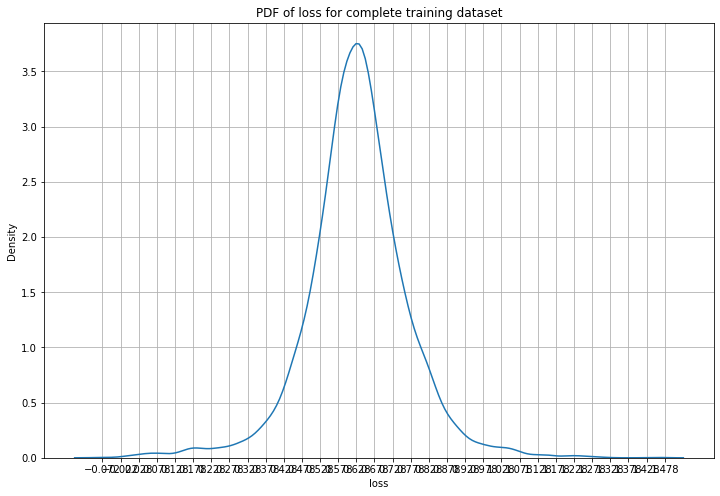

In [38]:
sns.kdeplot(df_train['loss'])
plt.title('PDF of loss for complete training dataset')
plt.xticks(np.arange(np.min(df_train['loss']), np.max(df_train['loss']) + 0.05, 0.05))
plt.grid()
plt.show()

In [39]:
losses = np.array(df_train['loss'])

In [40]:
for i in range(0, 110, 10):
    print(f"{i}th percentile = {np.round(np.percentile(losses, i), 3)}")

0th percentile = -0.072
10th percentile = 0.477
20th percentile = 0.539
30th percentile = 0.577
40th percentile = 0.603
50th percentile = 0.631
60th percentile = 0.655
70th percentile = 0.685
80th percentile = 0.724
90th percentile = 0.79
100th percentile = 1.453


#### Dividing the clips into 3 categories:
1. Best Performance: Minimal loss
2. Medium Performance: Average loss 
3. Worst Performance: Maximum loss

In [41]:
low_threshold = np.percentile(losses, 33.33)
mid_threshold = np.percentile(losses, 66.67)

In [42]:
df_best_perf  = df_train[df_train['loss'] <= low_threshold]
df_med_perf   = df_train[(df_train['loss'] > low_threshold) & (df_train['loss'] <= mid_threshold)]
df_worst_perf = df_train[df_train['loss'] > mid_threshold]

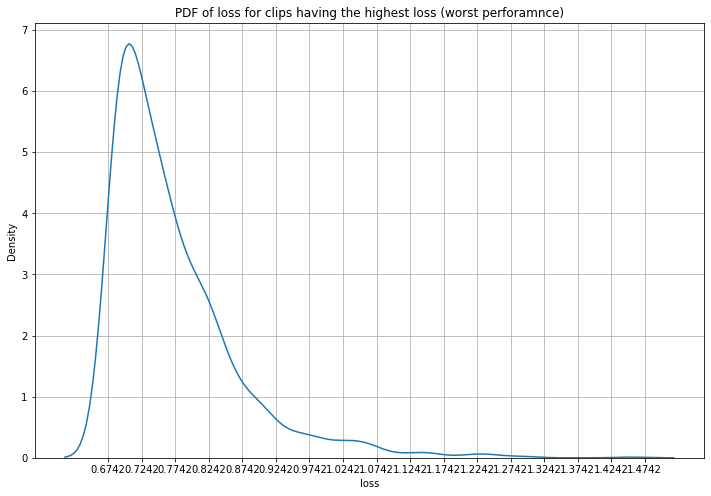

In [43]:
sns.kdeplot(df_worst_perf['loss'])
delta=0.05
plt.title('PDF of loss for clips having the highest loss (worst perforamnce)')
plt.xticks(np.arange(np.min(df_worst_perf['loss']), np.max(df_worst_perf['loss']) + delta, delta))
plt.grid()
plt.show()

#### Observations

1) The clips have a normal distribution and has a lower loss mostly and comparatively 

2) The pdf is skewed that means there is a some losses are very higher than average loss.

### Question: Effect of Number of labels with loss

Its possible as its a multi label classification problem so it becomes hard to for the model to classify it correctly.

In [44]:
def count_labels(s):
    return len(s.split(','))

In [45]:
df_best_perf['count_labels']  = df_best_perf['labels'].map(lambda x: count_labels(x))
df_med_perf['count_labels']   = df_med_perf['labels'].map(lambda x: count_labels(x))
df_worst_perf['count_labels'] = df_worst_perf['labels'].map(lambda x: count_labels(x))

In [46]:
df_best_perf['count_labels'].value_counts()/len(df_best_perf)*100

1    79.227053
2    17.874396
3     2.777778
4     0.120773
Name: count_labels, dtype: float64

In [47]:
df_med_perf['count_labels'].value_counts()/len(df_med_perf)*100

1    91.732046
2     7.664454
3     0.603500
Name: count_labels, dtype: float64

In [48]:
df_worst_perf['count_labels'].value_counts()/len(df_worst_perf)*100

1    86.775362
2    12.318841
3     0.785024
4     0.120773
Name: count_labels, dtype: float64

#### Observation:

Number of labels per clip leads to decrease in performance

### Searching the top 10 most occurring labels along with the number of clips for each label

In [49]:
best_perf_labels_count_dict = {}
for row in list(df_best_perf['labels']):
    for lab in row.split(','):
        if lab in best_perf_labels_count_dict:
            best_perf_labels_count_dict[lab]+=1
        else:
            best_perf_labels_count_dict[lab]=1

In [50]:
best_perf_labels_count_dict = dict(sorted(best_perf_labels_count_dict.items(), key=lambda item: item[1], reverse=True))

In [51]:
#Top 10 categories with the least misclassified points
c=0
for k, v in best_perf_labels_count_dict.items():
    if c==10: break
    print(k, ":", v)
    c+=1

Strum : 65
Acoustic_guitar : 64
Cheering : 60
Applause : 58
Child_speech_and_kid_speaking : 53
Bark : 52
Female_singing : 50
Harmonica : 49
Male_singing : 47
Electric_guitar : 46


In [52]:
med_perf_labels_count_dict = {}
for row in list(df_med_perf['labels']):
    for lab in row.split(','):
        if lab in med_perf_labels_count_dict:
            med_perf_labels_count_dict[lab]+=1
        else:
            med_perf_labels_count_dict[lab]=1

In [53]:
med_perf_labels_count_dict = dict(sorted(med_perf_labels_count_dict.items(), key=lambda item: item[1], reverse=True))

In [54]:
#Top 10 categories with the average misclassified points
c=0
for k, v in med_perf_labels_count_dict.items():
    if c==10: break
    print(k, ":", v)
    c+=1

Skateboard : 43
Drawer_open_or_close : 43
Shatter : 41
Hiss : 40
Waves_and_surf : 39
Zipper_(clothing) : 36
Chewing_and_mastication : 36
Microwave_oven : 35
Male_speech_and_man_speaking : 35
Marimba_and_xylophone : 33


In [55]:
worst_perf_labels_count_dict = {}
for row in list(df_worst_perf['labels']):
    for lab in row.split(','):
        if lab in worst_perf_labels_count_dict:
            worst_perf_labels_count_dict[lab]+=1
        else:
            worst_perf_labels_count_dict[lab]=1

In [56]:
worst_perf_labels_count_dict = dict(sorted(worst_perf_labels_count_dict.items(), key=lambda item: item[1], reverse=True))

In [57]:
#Top 10 categories with the most misclassified points
c=0
for k, v in worst_perf_labels_count_dict.items():
    if c==10: break
    print(k, ":", v)
    c+=1

Walk_and_footsteps : 50
Squeak : 46
Finger_snapping : 43
Clapping : 42
Toilet_flush : 39
Crackle : 38
Stream : 38
Tap : 37
Zipper_(clothing) : 37
Chink_and_clink : 37


### Question: Does the duration of the clip determines loss?

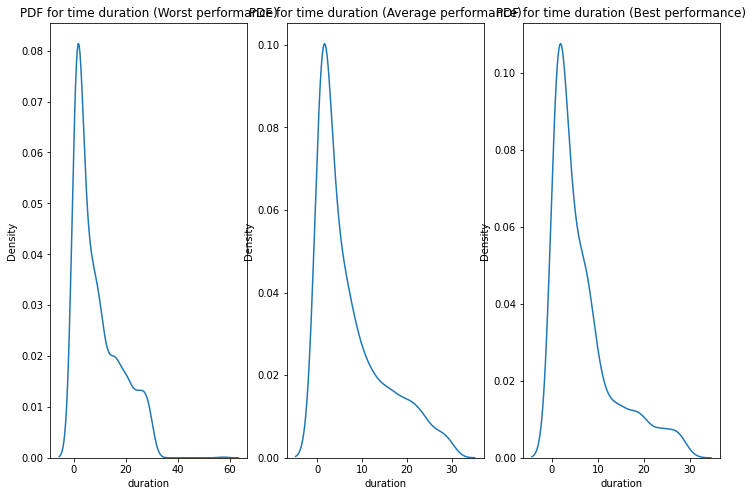

In [58]:
#Ref: https://stackoverflow.com/questions/41384040/subplot-for-seaborn-boxplot
#Ref: https://stackoverflow.com/questions/25239933/how-to-add-title-to-subplots-in-matplotlib

f, axes = plt.subplots(1, 3)

sns.kdeplot(df_worst_perf['duration'], ax=axes[0])
axes[0].title.set_text('PDF for time duration (Worst performance)')

sns.kdeplot(df_med_perf['duration'],   ax=axes[1])
axes[1].title.set_text('PDF for time duration (Average performance)')

sns.kdeplot(df_best_perf['duration'],  ax=axes[2])
axes[2].title.set_text('PDF for time duration (Best performance)')

**Observation: All the clips which are of long duration have high loss, this maybe true because, if the duration is very long, there can be many different sounds in the clip and the model can't predict all of them accurately leading to a higher loss**

### Listening to highest misclassified points

In [59]:
predictions_sigmoid = 1/(1+np.exp(-predictions_do))

In [60]:
freq_misclassified_labels=[]
for c,lab in enumerate(worst_perf_labels_count_dict.keys()):
    freq_misclassified_labels.append(lab)    
    if c==10: break

In [61]:
freq_misclassified_labels

['Walk_and_footsteps',
 'Squeak',
 'Finger_snapping',
 'Clapping',
 'Toilet_flush',
 'Crackle',
 'Stream',
 'Tap',
 'Zipper_(clothing)',
 'Chink_and_clink',
 'Slam']

In [62]:
def get_df_for_a_label(label):
    df_new = df_train[df_train['labels'].str.contains(label)]
    return df_new

### Class: Walk_and_footsteps

In [63]:
df_Walk_and_footsteps = get_df_for_a_label('Walk_and_footsteps')

In [64]:
df_Walk_and_footsteps.head()

fname                     labels  duration      loss  \
733   26f96160.wav  Walk_and_footsteps,Stream  9.146395  0.442753   
2800  90880403.wav  Walk_and_footsteps,Stream  6.844082  0.464913   
4718  f2cd4bc6.wav    Walk_and_footsteps,Slam  5.568571  0.502456   
4049  d15f0b6a.wav  Squeak,Walk_and_footsteps  9.593741  0.516332   
4735  f429c7f1.wav  Squeak,Walk_and_footsteps  8.008163  0.561321   

         predicted_label  
733   Walk_and_footsteps  
2800  Walk_and_footsteps  
4718                Slam  
4049  Walk_and_footsteps  
4735  Walk_and_footsteps

In [65]:
df_Walk_and_footsteps['predicted_label'].value_counts()[:5]

Walk_and_footsteps    40
Run                    9
Squeak                 4
Slam                   3
Microwave_oven         3
Name: predicted_label, dtype: int64

In [66]:
df_actual_Walk_and_footsteps_classified_Run = df_Walk_and_footsteps[df_Walk_and_footsteps['predicted_label'] == 'Run']

In [67]:
df_actual_Walk_and_footsteps_classified_Run

fname                  labels   duration      loss  \
3414  b0a8c445.wav  Walk_and_footsteps,Run   1.501542  0.601047   
3103  a10ae1af.wav  Walk_and_footsteps,Run   5.479909  0.667427   
3963  cc1e1258.wav  Walk_and_footsteps,Run   0.976190  0.695233   
2662  89975573.wav  Walk_and_footsteps,Run   7.238367  0.753628   
1380  47af9383.wav      Walk_and_footsteps   6.871429  0.781604   
3455  b2e12b81.wav      Walk_and_footsteps   9.991837  0.783941   
3424  b187ef20.wav  Walk_and_footsteps,Run   6.713061  0.794505   
3405  b014cdaf.wav      Walk_and_footsteps   9.931383  0.815422   
2588  85757f49.wav  Walk_and_footsteps,Run  20.183356  0.836331   

     predicted_label  
3414             Run  
3103             Run  
3963             Run  
2662             Run  
1380             Run  
3455             Run  
3424             Run  
3405             Run  
2588             Run

It can be clearly seen that the label also contained "Run" along with "Walk_and_footsteps" and hence the model predicted the label "Run" with highest prob., which is reasonable since both the labels are present.

####  Question - If "Walk_and_footsteps" is the 2nd/3rd most probable class

In [68]:
# Finding the top 5 class labels along with their probabilities for each datapoint containing "squeak" in its class label
indices = df_actual_Walk_and_footsteps_classified_Run.index
pred_squeak = [predictions_sigmoid[i] for i in indices]

sorted_indices = []
for i in range(len(pred_squeak)):
    sorted_indices.append(np.argsort(pred_squeak[i]))
    
top_5_indices = [sorted_indices[i][-5:][::-1] for i in range(len(sorted_indices))]

top_5_labels = []
for i in range(len(top_5_indices)):
    top_5_labels.append([label_dict[i] for i in top_5_indices[i]])
    
top_5_prob = []
for i in range(len(top_5_indices)):
    top_5_prob.append([pred_squeak[i][j] for j in top_5_indices[i]])

#### Sample Clip 1

In [69]:
for i in range(5):
    print(f"{top_5_labels[0][i]} : {round(top_5_prob[0][i], 3)}")

Run : 0.998
Walk_and_footsteps : 0.93
Stream : 0.0
Squeak : 0.0
Skateboard : 0.0


#### Sample Clip 2

In [70]:
for i in range(5):
    print(f"{top_5_labels[1][i]} : {round(top_5_prob[1][i], 3)}")

Run : 0.997
Walk_and_footsteps : 0.073
Squeak : 0.0
Chewing_and_mastication : 0.0
Knock : 0.0


#### Sample Clip 3

In [71]:
for i in range(5):
    print(f"{top_5_labels[2][i]} : {round(top_5_prob[2][i], 3)}")

Run : 0.994
Walk_and_footsteps : 0.017
Drawer_open_or_close : 0.002
Slam : 0.0
Zipper_(clothing) : 0.0


**Observation: All of the 3 sample clips contain Walk_and_footsteps in the top 5 labels, hence, the model is able to identify it, however with difficulty.**

### Class: Squeak

In [72]:
df_Squeak = get_df_for_a_label('Squeak')

In [73]:
df_Squeak.head()

fname                     labels  duration      loss  \
3161  a3e0e767.wav                Squeak,Slam  8.385306  0.361683   
776   28c5265e.wav     Squeak,Chirp_and_tweet  3.284943  0.375905   
2677  8aa9e939.wav             Squeak,Writing  2.750023  0.445042   
158   086716f4.wav             Squeak,Writing  5.250023  0.496170   
4049  d15f0b6a.wav  Squeak,Walk_and_footsteps  9.593741  0.516332   

         predicted_label  
3161                Slam  
776      Chirp_and_tweet  
2677             Writing  
158              Writing  
4049  Walk_and_footsteps

In [74]:
df_Squeak['predicted_label'].value_counts()[:5]

Slam                      18
Squeak                    16
Cupboard_open_or_close     8
Walk_and_footsteps         7
Electric_guitar            4
Name: predicted_label, dtype: int64

**All these sounds are very similar to each other and many times also present in the actual class labels, so, the model is not making any mistake here**

### Listening the top 10 points with the Maximum loss

In [75]:
df_train['count_labels']  = df_train['labels'].map(lambda x: count_labels(x))

In [76]:
top_10_points_having_highest_loss = df_train[-10:]
top_10_points_having_highest_loss

fname                                             labels  \
4201  d9a5261c.wav  Male_speech_and_man_speaking,Female_speech_and...   
2215  729d5073.wav             Frying_(food),Dishes_and_pots_and_pans   
2559  842025a3.wav                               Chirp_and_tweet,Buzz   
2882  9579b1c8.wav                        Electric_guitar,Bass_guitar   
3929  ca00ee02.wav      Trickle_and_dribble,Sink_(filling_or_washing)   
3935  ca5eebba.wav                      Squeak,Cupboard_open_or_close   
841   2c47750e.wav                          Fart,Drawer_open_or_close   
1409  4976177e.wav                        Electric_guitar,Bass_guitar   
1709  58b5d8d7.wav  Female_speech_and_woman_speaking,Walk_and_foot...   
1148  3c13f5cd.wav                                  Bark,Cricket,Buzz   

       duration      loss                     predicted_label  count_labels  
4201   3.500408  1.206961                              Sneeze             2  
2215   9.215238  1.208795                      Waves_and_surf             2  
2559  20.332834  1.225717             Chewing_and_mastication             2  
2882   9.959683  1.228893                               Strum             2  
3929   5.294150  1.234880                  Fill_(with_liquid)             2  
3935   9.409932  1.244371                      Microwave_oven             2  
841    2.690612  1.251893  Accelerating_and_revving_and_vroom             2  
1409   4.165125  1.283691  Accelerating_and_revving_and_vroom             2  
1709  18.328707  1.298052                      Microwave_oven             2  
1148  22.963673  1.452919                              Stream             3

In [77]:
points_with_highest_loss_fnames = list(top_10_points_having_highest_loss['fname'])

indices = top_10_points_having_highest_loss.index
pred_high_loss = [predictions_sigmoid[i] for i in indices]

sorted_indices = []
for i in range(len(pred_high_loss)):
    sorted_indices.append(np.argsort(pred_high_loss[i]))
    
top_5_indices = [sorted_indices[i][-5:][::-1] for i in range(len(sorted_indices))]

top_5_labels = []
for i in range(len(top_5_indices)):
    top_5_labels.append([label_dict[i] for i in top_5_indices[i]])
    
top_5_prob = []
for i in range(len(top_5_indices)):
    top_5_prob.append([pred_high_loss[i][j] for j in top_5_indices[i]])

In [81]:
train_data_path = r'/content/gdrive/MyDrive/Freesound_new/train_combined'

### 1st Clip

In [82]:
filename = train_data_path + '/' + points_with_highest_loss_fnames[-1]
IPython.display.Audio(filename = filename)

In [83]:
print("Actual class labels -> \n")
for label in top_10_points_having_highest_loss[-1:].labels.values[0].split(','):
    print(label)
    
print("\n\nPredicted class labels -> \n")
for i in range(5):
    print(f"{top_5_labels[-1][i]} : {round(top_5_prob[-1][i], 10)}")

Actual class labels -> 

Bark
Cricket
Buzz


Predicted class labels -> 

Stream : 0.3818813966
Writing : 0.0008886085
Crackle : 7.0614e-06
Scissors : 3.4858e-06
Meow : 2.5065e-06


### 2nd Clip

In [84]:
filename = train_data_path + '/' + points_with_highest_loss_fnames[-2]
IPython.display.Audio(filename = filename)

In [85]:
print("Actual class labels -> \n")
for label in top_10_points_having_highest_loss[-2:].labels.values[0].split(','):
    print(label)
    
print("\n\nPredicted class labels -> \n")
for i in range(5):
    print(f"{top_5_labels[-2][i]} : {round(top_5_prob[-2][i], 10)}")

Actual class labels -> 

Female_speech_and_woman_speaking
Walk_and_footsteps


Predicted class labels -> 

Microwave_oven : 0.0021676301
Screaming : 3.64679e-05
Motorcycle : 3.50878e-05
Crowd : 5.3417e-06
Printer : 1.9409e-06


### 3rd Clip

In [86]:
filename = train_data_path + '/' + points_with_highest_loss_fnames[-3]
IPython.display.Audio(filename = filename)

In [87]:
print("Actual class labels -> \n")
for label in top_10_points_having_highest_loss[-3:].labels.values[0].split(','):
    print(label)
    
print("\n\nPredicted class labels -> \n")
for i in range(5):
    print(f"{top_5_labels[-3][i]} : {round(top_5_prob[-3][i], 10)}")

Actual class labels -> 

Electric_guitar
Bass_guitar


Predicted class labels -> 

Accelerating_and_revving_and_vroom : 0.0001534021
Chink_and_clink : 6.85434e-05
Strum : 5.90399e-05
Acoustic_guitar : 1.87376e-05
Bark : 7.5959e-06


### 4th Clip 

In [88]:
filename = train_data_path + '/' + points_with_highest_loss_fnames[-4]
IPython.display.Audio(filename = filename)

In [89]:
print("Actual class labels -> \n")
for label in top_10_points_having_highest_loss[-4:].labels.values[0].split(','):
    print(label)
    
print("\n\nPredicted class labels -> \n")
for i in range(5):
    print(f"{top_5_labels[-4][i]} : {round(top_5_prob[-4][i], 10)}")

Actual class labels -> 

Fart
Drawer_open_or_close


Predicted class labels -> 

Accelerating_and_revving_and_vroom : 0.0002003292
Motorcycle : 1.8504e-06
Buzz : 7.7e-07
Race_car_and_auto_racing : 2.554e-07
Male_singing : 2.304e-07


## Top 10 data points with the minimal loss

In [90]:
top_10_points_having_least_loss = df_train[:10]
top_10_points_having_least_loss

fname                 labels  duration      loss  \
3862  c5f737a6.wav  Acoustic_guitar,Strum  9.841542 -0.072017   
2498  813f9535.wav  Acoustic_guitar,Strum  9.877551 -0.007386   
3309  abbf4f95.wav  Acoustic_guitar,Strum  9.928980 -0.001376   
4571  ec748565.wav  Acoustic_guitar,Strum  7.823129  0.003414   
1062  378b39f6.wav  Acoustic_guitar,Strum  7.279955  0.008189   
3936  ca74df21.wav  Acoustic_guitar,Strum  8.171791  0.025676   
4688  f134afbb.wav  Acoustic_guitar,Strum  8.132880  0.035006   
2745  8dd9e0c2.wav  Acoustic_guitar,Strum  7.393333  0.039642   
3697  bf30ec1d.wav  Acoustic_guitar,Strum  9.170249  0.045790   
1847  5fe5138b.wav  Acoustic_guitar,Strum  9.004218  0.046303   

      predicted_label  count_labels  
3862  Acoustic_guitar             2  
2498  Acoustic_guitar             2  
3309  Acoustic_guitar             2  
4571  Acoustic_guitar             2  
1062  Acoustic_guitar             2  
3936  Acoustic_guitar             2  
4688  Acoustic_guitar             2  
2745  Acoustic_guitar             2  
3697  Acoustic_guitar             2  
1847  Acoustic_guitar             2

**Observations:  <br>The model classifies each point correctly even though the fact that these are of different durations, which means, the model is capable of correctly classifying clips of long durations when the number of labels per clip is less and the sounds are less ambigous.**

## Final Conclusion:

Overall, the model performs well on most points, with only a some outliers exhibiting high loss. Specifically, the model works best on clips with a single label and low to moderate background noise. However, there are some limitations to its performance that need to be considered.

1) The model struggles to identify all correct labels when a clip contains multiple labels (more than two) and there are very similar sounds present, such as water_tap_and_faucet, drip, fill_(with_liquid), and so on. This is a challenging problem even for humans, as the nuances in these environmental sounds can be difficult to distinguish.

2) The model's performance also depends on the duration of the clip. Very short clips (1-2 seconds) are often too brief to capture enough environmental sound, making it challenging for the model to classify them correctly. Similarly, very long clips (>15 seconds) with many labels and background noise can also pose problems, as the model may only predict the most salient labels and miss the nuanced ones. However, this is also a common behavior observed in human perception of environmental sounds.

Overall, the model's optimal performance is achieved when the clip is of moderate duration, contains a single label, and has low background noise. Adding more labels does not cause any significant issues unless the background noise is too high to discern the subtle nuances of each sound. It's important to keep in mind that the task of classifying environmental sounds, especially similar ones, is challenging even for humans, and the model's performance is comparable to that of a human in most cases.